## Packages
Install necessary packages: numpy, control, and multiprocessing.

In [1]:
!pip install -r requirements.txt -U


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary packages
import re

import numpy as np
import control as ct

from typing import Callable, Tuple

import matplotlib.pyplot as plt

## Plot
Given a transfer function **H**, frequency range **\[start, end\]**, and propagation delay **delay**, we numerically approximate the transfer function given a square wave amplifier, which theoretically produces an infinite number of harmonics. If there is no propagation delay or it is already approximated in the transfer function, **delay** defaults to the floating point ε to approximate the limit form mentioned in Putzey's paper.

In [3]:
from modules.calc_resp import precompute_consts, calc_resp

def calc(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps,
    num_freqs=1_000,
    num_duty_cycles=100,
    num_harmonics=100.
) -> Tuple[np.ndarray]:
    consts = list(precompute_consts(num_freqs, num_duty_cycles, num_harmonics, (start, end)))
    
    mags, phs, osc_fs, dcins, dcgains, margins = calc_resp(np.array(H.num[0])[:,::-1], np.array(H.den[0])[:,::-1], np.array([delay]), *consts)

    margins = np.degrees(margins)
    print(np.min(margins, axis=1))
    consts[0] = np.imag(consts[0]) / (2 * np.pi)
    osc_fs /= 2 * np.pi
    phs -= np.pi

    return (mags[0], phs[0], osc_fs[0], dcins[0], dcgains[0]), consts[:3]

In [4]:
def plot(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps
) -> None:
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs.
    frequency, oscillation frequency vs. duty cycle, DC transfer curve, and loop gain 
    vs. duty cycle. """

    (mags, phs, osc_fs, dcins, dcgains), (omega, hs, ns) = calc(H, start, end, delay)
    
    # Plotting
    fig, ((ax_ph, ax_dcgain), (ax_osc, ax_dcin)) = plt.subplots(2,2)

    # Set figure labels
    ax_osc.set_ylabel('Osc. Freq. (Hz)')
    ax_osc.set_xlabel('Duty Cycle')

    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_ylabel('Phase (°)')
    ax_mag = ax_ph.twinx()
    ax_mag.set_ylabel('Magnitude (dB)')

    # Plot phase
    cs = ['b','g','c','y']
    for i, p in enumerate(phs[-1:0:-(hs.size // 5),:]):
        ax_ph.plot(omega, np.degrees(np.unwrap(p)), f'{cs[i % len(cs)]}--')

    ax_ph.plot([start, end], [-180, -180], 'k:')
    ax_ph.set_xscale('log')

    max_ph = max(np.ceil(np.degrees(np.max(phs))), 0) + 10
    ax_ph.set_yticks([0, -180, -360])
    ax_ph.set_ylim(-360-max_ph, max_ph)

    # Plot oscillation frequencies
    ax_osc.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((osc_fs, osc_fs[-1::-1]))
    )

    # Plot dcin
    ax_dcin.plot(
        np.concatenate((-dcins, dcins[-1::-1])),
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1))
    )

    # Plot dcgain
    ax_dcgain.plot(
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1)),
        np.concatenate((dcgains, dcgains[-1::-1]))
    )

    # Plot magnitudes
    mag_scaled = 20 * np.log10(dcgains[-1] * np.absolute(H(2j * np.pi * omega)))
    ax_mag.plot(omega, mag_scaled, 'r-')
    
    max_mag = round(max(
        *map(
            np.abs, 
            (np.min(mag_scaled), np.max(mag_scaled))
        ), 
        0
    )) + 3
    ax_mag.set_ylim(-max_mag, max_mag)

    fig.tight_layout()



## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

## Workspace

In [5]:
from modules.sapwin import Sapwin

problem = Sapwin(filename='../sym_analysis/SapWin/class_d_3.out', n_fs=1_000, n_hs=20, n_ns=150)

In [6]:
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS

algorithm = DE(
    pop_size=500,
    sampling=LHS(),
    variant='DE/best/1/bin',
    CR=0.9,
    F=1.8,
    dither='vector',
    jitter=True
)

In [7]:
from numba import set_num_threads
set_num_threads(2)

In [8]:
from pymoo.optimize import minimize

res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 100),
    seed=1,
    save_history=True,
    verbose=True
)

/mnt/c/Users/Aaron/Documents/GitHub/class-d-amp/loop_analysis/python/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      500 |           INF |  0.8450516413
     2 |     1000 | 3.595386E+305 |  0.0126264777
     3 |     1500 |  3.650335E+03 |  0.0108788538
     4 |     2000 |  1.419280E+03 |  0.0099446171
     5 |     2500 |  2.220437E+02 |  0.0020283586
     6 |     3000 |  2.354918E+01 |  0.0004968391
     7 |     3500 |  1.236963E+01 |  0.0004968391
     8 |     4000 |  7.3295661854 |  0.0004968391
     9 |     4500 |  3.8250982369 |  0.0003204271
    10 |     5000 |  2.2330342570 |  0.0003204271
    11 |     5500 |  1.4578163052 |  0.0002831953
    12 |     6000 |  1.2890844558 |  0.0002831953
    13 |     6500 |  1.2478845812 |  0.0002831953
    14 |     7000 |  0.4482482097 |  0.0002831953
    15 |     7500 |  0.3024624788 |  0.0002831953
    16 |     8000 |  0.2642038162 |  0.0002831953
    17 |     8500 |  0.2164973620 |  0.0002831953
    18 |     9000 |  0.1620473914 |  0.0002708076
    19 |     9500 |  0.0448109566 |  0.0002708076


/mnt/c/Users/Aaron/Documents/GitHub/class-d-amp/loop_analysis/python/modules/problem.py:59: RuntimeWarning: overflow encountered in multiply
  min_gain = 1 / np.min((mag[:,None,f_band] * dcgains[:,p_band,None]), axis=(1,2))


    62 |    31000 |  0.0004251378 |  0.0002353442
    63 |    31500 |  0.0004206901 |  0.0002353442
    64 |    32000 |  0.0004151215 |  0.0002353442
    65 |    32500 |  0.0004122870 |  0.0002353442
    66 |    33000 |  0.0004068298 |  0.0002353442
    67 |    33500 |  0.0004015964 |  0.0002353442
    68 |    34000 |  0.0003984988 |  0.0002353442
    69 |    34500 |  0.0003934140 |  0.0002353442
    70 |    35000 |  0.0003903360 |  0.0002353442
    71 |    35500 |  0.0003873634 |  0.0002353442
    72 |    36000 |  0.0003832797 |  0.0002349300
    73 |    36500 |  0.0003809727 |  0.0002349300
    74 |    37000 |  0.0003787092 |  0.0002349300
    75 |    37500 |  0.0003771202 |  0.0002349300
    76 |    38000 |  0.0003739515 |  0.0002349300
    77 |    38500 |  0.0003709480 |  0.0002349300
    78 |    39000 |  0.0003695278 |  0.0002349300
    79 |    39500 |  0.0003649764 |  0.0002238666
    80 |    40000 |  0.0003560745 |  0.0002004428
    81 |    40500 |  0.0003503849 |  0.0001477060


In [9]:
X = res.X
F = res.F

In [10]:
print(' '.join(map(lambda v, x: f'{v}:{x:.2E}' , problem._vars, X)))

Cf:9.41E-05 Cif:3.38E-05 Cl:5.66E-09 Lf:9.15E-04 R10:9.83E+04 R11:1.13E+02 R4:9.99E+04 R6:3.36E+02 Rl:1.00E+02


[268.32250806]


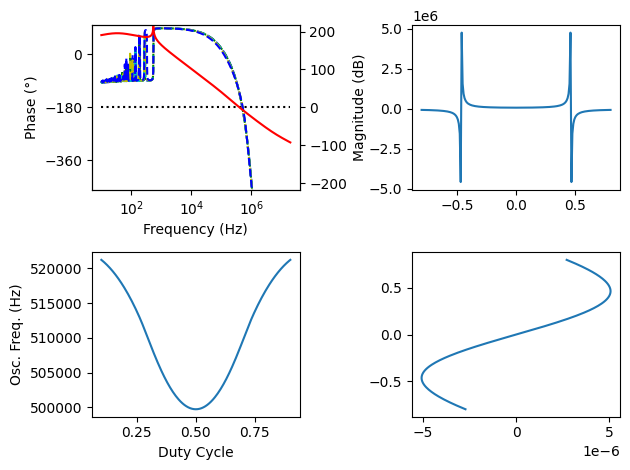

In [11]:
vals = X[:-1][None,:]
delay = X[-1]

num = problem._calc_num(vals)[0,::-1]
den = problem._calc_den(vals)[0,::-1]

plot(ct.tf(num, den), 10, 2e7, delay)